# Fitting a POPC lipid bilayer on Si in two contrasts, with separate measurements of the substrate with no bilayer. The notebook performs MCMC sampling, and then autocorrelation analysis to determine the optimal thinning and burn points
***


Tags: LipidLeaflet, MCMC, Autocorrelation, Sampling

#### Imports:

In [1]:
# use matplotlib for plotting

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import copy, os

# the analysis module contains the curvefitting engine
from refnx.analysis import CurveFitter, Objective, Parameter, GlobalObjective

# the reflect module contains functionality relevant to reflectometry
from refnx.reflect import SLD, ReflectModel, LipidLeaflet

# the ReflectDataset object will contain the data
from refnx.dataset import ReflectDataset

#### Data loading:

In [2]:
pth = r'./'  # You can change the pather here to the datasets, currently they lie in the same folder

data_d2o = ReflectDataset(os.path.join(pth, 'Si_D2O_HEPES_20mM_POPC_1h.dat'))
data_bd2o = ReflectDataset(os.path.join(pth, 'Si_D2O_HEPES_20mM.dat'))
data_h2o = ReflectDataset(os.path.join(pth, 'Si_H2O_HEPES_20mM_POPC_1h.dat'))
data_bh2o = ReflectDataset(os.path.join(pth, 'Si_H2O_HEPES_20mM.dat'))


#### Model definition:

In [3]:
si = SLD(2.07)
sio2 = SLD(3.47)

# the following represent the solvent contrasts used in the experiment
d2o = SLD(6.36)
h2o = SLD(-0.56)
smw = SLD(2.07)

# The water also contained buffers which were mostly hydrogenous, meaning we will be unlikely to have 
# pure D2O. Therefore we allow it's SLD to vary a little
d2o.real.setp(6.01, vary=False, bounds=(5.5, 6.36))
d2o.real.name='d2o SLD'

In [5]:
# Parameter for the area per molecule each POPC molecule occupies at the surface. We
# use the same area per molecule for the inner and outer leaflets

apm = Parameter(60, 'area per molecule', vary=True, bounds=(50, 79))

# the sum of scattering lengths for the lipid head and tail in Angstrom
b_heads = Parameter(6.01e-4, 'b_heads')
b_tails = Parameter(-2.92e-4, 'b_tails')

# the volume occupied by the head and tail groups in cubic Angstrom
v_heads = Parameter(320.9, 'v_heads')
v_tails = Parameter(881.64, 'v_tails')

# the head and tail group thicknesses.
inner_head_thickness = Parameter(9, 'inner_head_thickness', vary=True, bounds=(4, 15))
tail_thickness = Parameter(14, 'tail_thickness', vary=True, bounds=(10, 19))

# finally construct a `LipidLeaflet` object for the inner and outer leaflets
# Note that here the inner and outer leaflets use the same area per molecule,
# same tail thickness, etc.
inner_leaflet = LipidLeaflet(apm,
                             b_heads, v_heads, inner_head_thickness,
                             b_tails, v_tails, tail_thickness,
                             3, 3)

# we reverse the monolayer for the outer leaflet because the tail groups face the other way
outer_leaflet = LipidLeaflet(apm,
                             b_heads, v_heads, inner_head_thickness,
                             b_tails, v_tails, tail_thickness,
                             3, 0, reverse_monolayer=True)

In [6]:
# Slab of silicon dioxide constructed from the SLD object

sio2_slab = sio2(15, 3)
sio2_slab.thick.setp(vary=True, bounds=(10, 30))
sio2_slab.thick.name = 'sio2 thickness'
sio2_slab.rough.setp(3, vary=False, bounds=(1, 11))
sio2_slab.rough.name = 'sio2 roughness'
sio2_slab.vfsolv.setp(0.10, vary=True, bounds=(0.0, 0.8))
sio2_slab.vfsolv.name = 'sio2 solvation'

solv_roughness = Parameter(3, 'bilayer/solvent roughness')
solv_roughness.setp(vary=True, bounds=(1, 9))

In [7]:
# Define the sample structures with and without the lipid layers present

s_d2o = si | sio2_slab | inner_leaflet | outer_leaflet | d2o(0, solv_roughness)  # s stands for sample
s_h2o = si | sio2_slab | inner_leaflet | outer_leaflet | h2o(0, solv_roughness)

b_d2o = si | sio2_slab | d2o(0, solv_roughness)  # b stands for bare
b_h2o = si | sio2_slab | h2o(0, solv_roughness)

In [8]:
# Set backgrounds and scale factors for the experiments

model_d2o = ReflectModel(s_d2o)
model_h2o = ReflectModel(s_h2o)
model_d2o.scale.setp(0.89)
model_h2o.scale.setp(0.89)
model_d2o.bkg.setp(4e-6)
model_h2o.bkg.setp(5e-6)
model_bd2o = ReflectModel(b_d2o)
model_bh2o = ReflectModel(b_h2o)
model_bd2o.scale.setp(0.89)
model_bh2o.scale.setp(0.89)
model_bd2o.bkg.setp(4e-6)
model_bh2o.bkg.setp(5e-6)

In [9]:
# Create refnx Objectives, linking the models and the datasets
# Create GlobalObjectives to co-refine all the models for each experiment

objective_d2o = Objective(model_d2o, data_d2o)
objective_h2o = Objective(model_h2o, data_h2o)
objective_bd2o = Objective(model_bd2o, data_bd2o)
objective_bh2o = Objective(model_bh2o, data_bh2o)


global_objective = GlobalObjective([objective_bd2o, objective_bh2o, objective_d2o, objective_h2o])

## Performing the fitting

In [10]:
conventional_fitter = CurveFitter(global_objective)

In [11]:
conventional_result = conventional_fitter.fit('differential_evolution')

-5278.158947529867: : 21it [00:02,  8.61it/s]/Users/joshanielcooper/anaconda3/envs/Hogben/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
-5278.158947529867: : 21it [00:02,  8.07it/s]


In [11]:
conventional_parameters = copy.deepcopy(global_objective.varying_parameters())

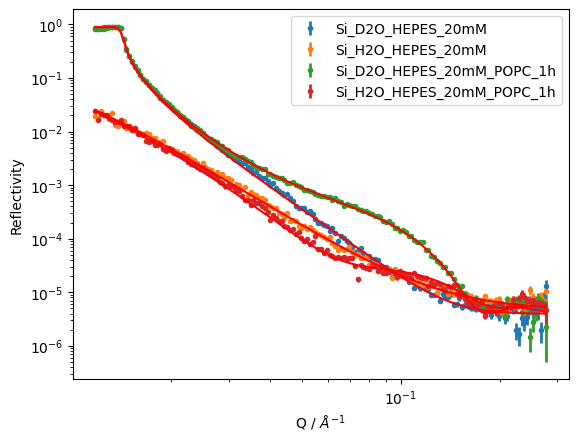

In [12]:
global_objective.plot()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Q / $\AA^{-1}$')
plt.ylabel('Reflectivity')
plt.legend();
plt.savefig('conventional.png', dpi=300);

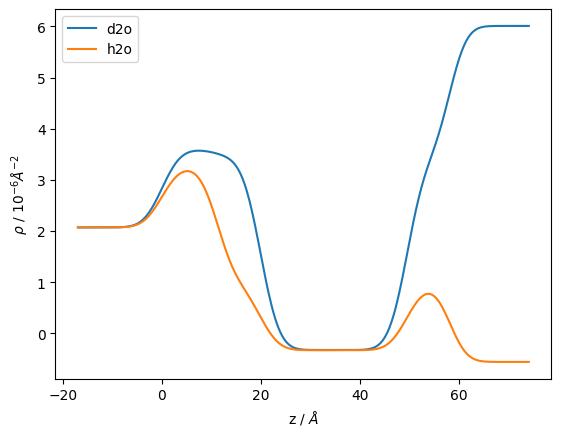

In [13]:
fig, ax = plt.subplots()
ax.plot(*s_d2o.sld_profile(), label='d2o')
ax.plot(*s_h2o.sld_profile(), label='h2o')

ax.set_ylabel("$\\rho$ / $10^{-6} \AA^{-2}$")
ax.set_xlabel("z / $\AA$")
ax.legend();

### Do some MCMC sampling:

In [ ]:
conventional_fitter.sample(500, random_state=1);
conventional_fitter.sampler.reset();
conventional_fitter.sample(10000, nthin=1, random_state=2);  # nthin=60 (varies each time a little) comes from autocorrelation analysis below, run with n_thin=1 to get estimate of what to use
# (see markdowncells below for the code)
conventional_parameters = copy.deepcopy(global_objective.varying_parameters())

  0%|          | 0/500 [00:00<?, ?it/s]/Users/joshanielcooper/anaconda3/envs/Hogben/lib/python3.11/site-packages/refnx/_lib/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [14:06<00:00, 11.81it/s]


In [15]:
## From https://emcee.readthedocs.io/en/stable/tutorials/autocorr/#autocorr 

def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i


def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

## Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1


## Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

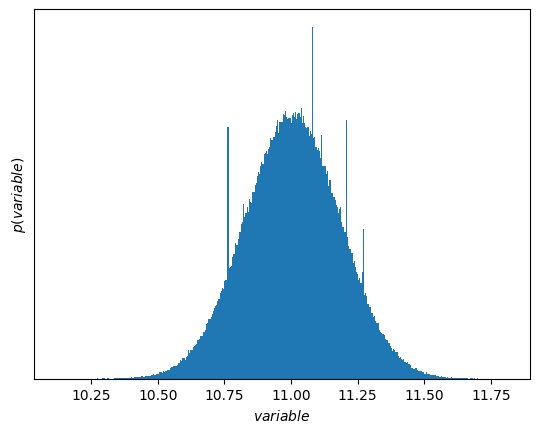

In [16]:
chain = conventional_fitter.sampler.get_chain()[:, :, 0].T  # Have a look at one of the parameters' distributions

plt.hist(chain.flatten(), 400)
plt.gca().set_yticks([])
plt.xlabel(r"$variable$")
plt.ylabel(r"$p(variable)$");

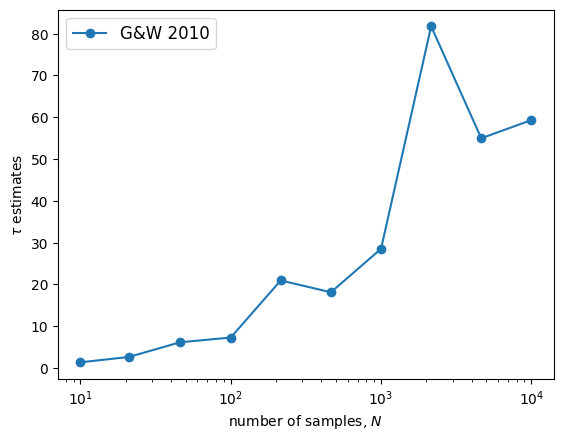

In [17]:
## Compute the estimator for a few different chain lengths
N = np.exp(np.linspace(np.log(10), np.log(chain.shape[1]), 10)).astype(int)
gw2010 = np.empty(len(N))
for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(chain[:, :n])

## Plot the autocorrelation
plt.semilogx(N, gw2010, "o-", label="G&W 2010")
ylim = plt.gca().get_ylim()
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=12);

In [18]:
print(conventional_parameters)

________________________________________________________________________________
Parameters:      None      
<Parameter:'sio2 thickness', value=11.0074 +/- 0.182, bounds=[10.0, 30.0]>
<Parameter:'sio2 solvation', value=0.0529176 +/- 0.00754, bounds=[0.0, 0.8]>
<Parameter:'bilayer/solvent roughness', value=2.04212 +/- 0.305, bounds=[1.0, 9.0]>
<Parameter:'area per molecule', value=59.201 +/- 0.186, bounds=[50.0, 79.0]>
<Parameter:'inner_head_thickness', value=8.87204 +/- 0.164, bounds=[4.0, 15.0]>
<Parameter:'tail_thickness', value=14.9103 +/- 0.0492, bounds=[10.0, 19.0]>


In [29]:
conventional_fitter.sampler.get_autocorr_time()

array([78.19436835, 82.64826501,         nan, 79.28486501, 76.86325599,
       87.26648735])

In [28]:
print(f'Acceptance fraction  = {np.mean(conventional_fitter.sampler.acceptance_fraction)}') 
print(f'Autocorrelation time = {np.mean(conventional_fitter.sampler.get_autocorr_time()[np.isfinite(conventional_fitter.sampler.get_autocorr_time())])}')

Acceptance fraction  = 0.46974999999999995
Autocorrelation time = 80.85144834216244


In [20]:
# Since we did sampling we want to get the covariance matrix of the parameters from the MCMC rather than the fitting
# Partially flatten the chains into parameters 

chain = conventional_fitter.sampler.get_chain().T

length = chain.shape[1]*chain.shape[2]
flatchain = chain.reshape(6, length)


# Compute the covariance matrix of the flattened chain
conventional_covariance = np.cov(flatchain)


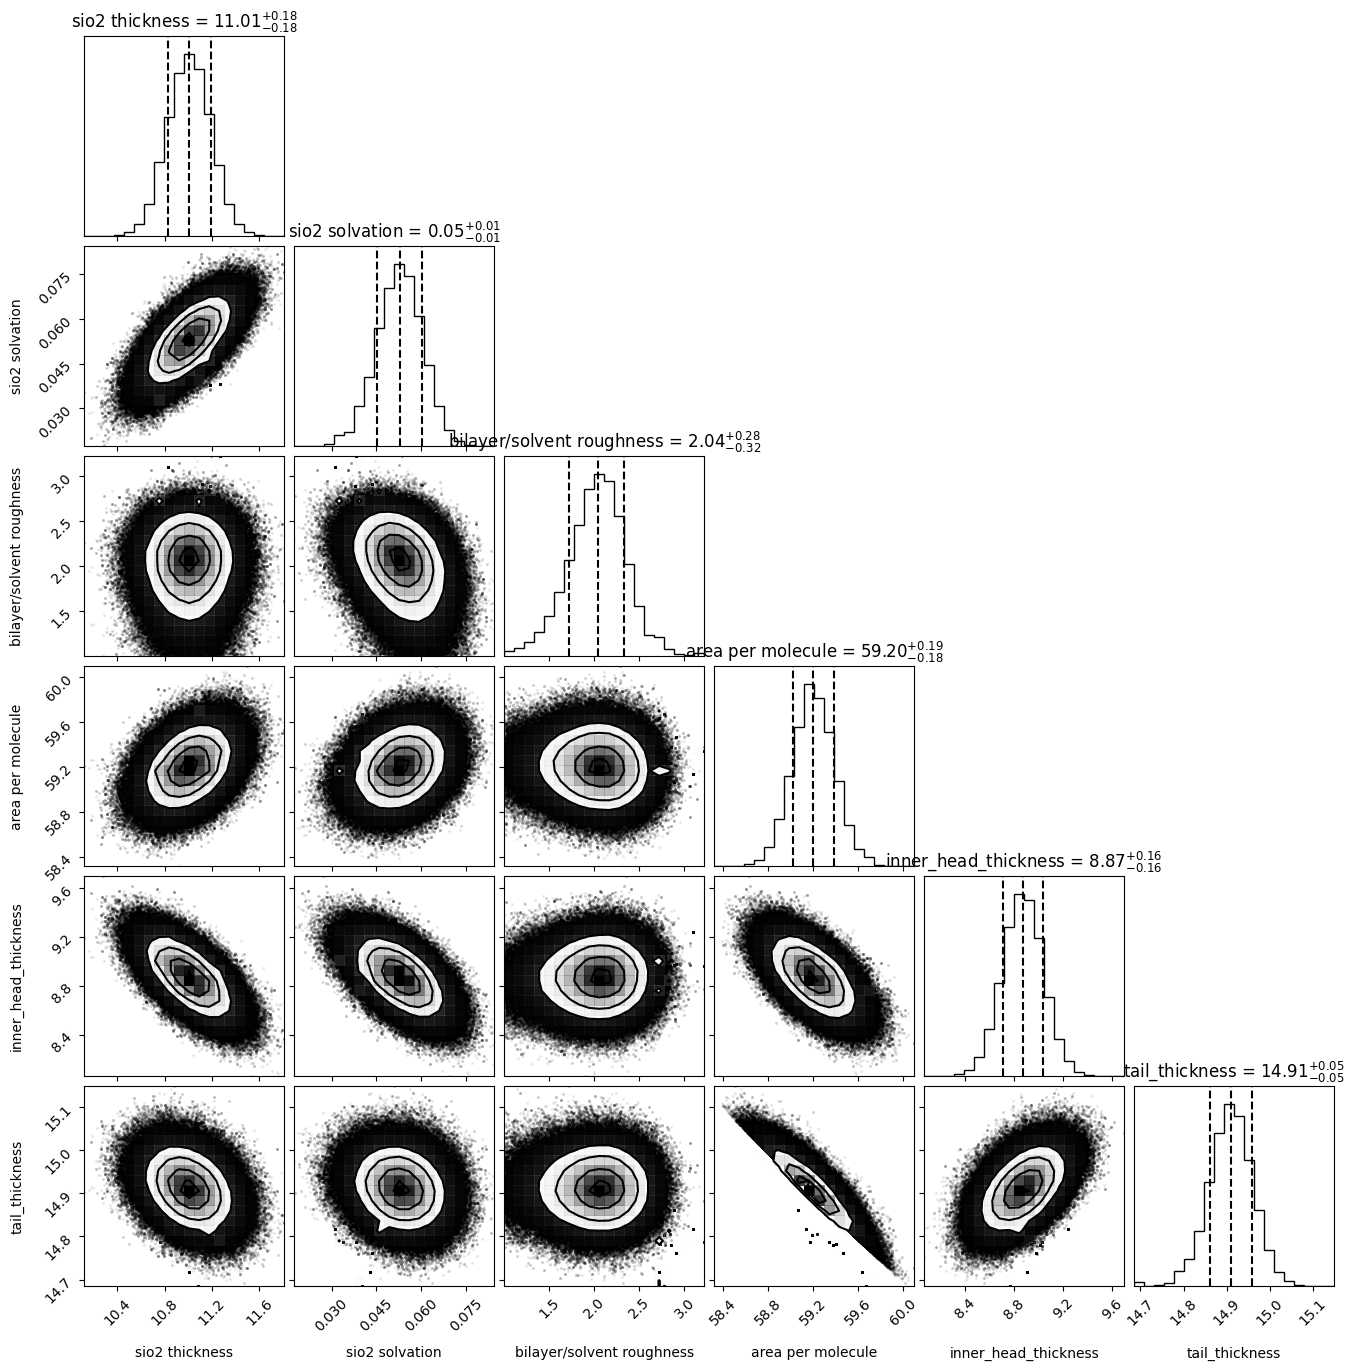

In [21]:
conventional_corner = global_objective.corner(show_titles=True);

### Save the corner plot and write out the parameters

In [22]:
conventional_corner.savefig("POPC_conventional_corner.png", dpi=400)

In [23]:
with open('test.txt', 'w') as file:
    file.write(f'\n Fitted parameters \n {conventional_parameters} \n')
